In [27]:
import os
from google.colab import drive
# mount Google drive
drive.mount('/content/drive')


# by default everything gets executed and saved in 'Berkeley Capstone (Students)'
notebook_path = '/content/drive/MyDrive/Berkeley Capstone (Students)/Code' # WK
# notebook_path = '/content/drive/MyDrive/Capstone/Berkeley Capstone (Students)/Code' # GQ
os.chdir(notebook_path)

!echo -e "\nCurrent directory:"
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Current directory:
/content/drive/.shortcut-targets-by-id/1yBERxWlYaZqd2aPZEzBr21t8G6McvwZA/Berkeley Capstone (Students)/Code


In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
from collections import defaultdict
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [3]:
# df = pd.read_csv('week_norm_all_withweek.csv') # norm on whole dataset
df = pd.read_csv('ExtractedData/sessionnact50r4.2.csv')
# df = pd.read_csv('Copy of week.csv')
df.shape

(956502, 129)

In [4]:
import torch

if torch.cuda.is_available():
    print('Found GPU')
else:
    print('Did not find GPU')

Found GPU


# Data Process

In [20]:
from dataloader_ import df_to_tensor
from sklearn import preprocessing

In [21]:
def get_features(df, removed_cols):
    x_cols = [i for i in df.columns if i not in removed_cols]
    return x_cols

def split_dataset(data, x_cols, split_eval=False):

    if split_eval:
      # train : validation : test = 4:2:4
      data1stHalf = data[data.week <= max(data.week)*0.6]
      dataTest = data[data.week > max(data.week)*0.4]
    else:
      data1stHalf = data[data.week <= max(data.week)/2]
      dataTest = data[data.week > max(data.week)/2]

    selectedTrainUsers =  set(data1stHalf[data1stHalf.insider > 0]['user'])
    unKnownTestUsers = list(set(dataTest.user) - selectedTrainUsers)

    test = dataTest[dataTest.user.isin(unKnownTestUsers)][x_cols]

    if split_eval:
      data_train, data_val = data1stHalf[data1stHalf.week <= max(data1stHalf.week)*2/3], data1stHalf[data1stHalf.week > max(data1stHalf.week)*2/3]

      train = data_train[x_cols]
      val = data_val[x_cols]
      all = np.concatenate((train, val, test))

      return all, train, val, test
    else:
      train = data1stHalf[x_cols]
      all = np.concatenate((train, test))
    
      return all, train, test

In [22]:
df.head()

,subs_ind,starttime,endtime,user,sessionid,day,week,pc,isworkhour,isafterhour,...,http_leakf_mean_url_len,http_leakf_mean_url_depth,http_leakf_mean_http_c_len,http_leakf_mean_http_c_nwords,http_n_hackf,http_hackf_mean_url_len,http_hackf_mean_url_depth,http_hackf_mean_http_c_len,http_hackf_mean_http_c_nwords,insider
0,0,1.262423e+09,1.262456e+09,10,0,5,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
1,0,1.262421e+09,1.262434e+09,12,1,5,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
2,0,1.262435e+09,1.262451e+09,12,2,5,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
3,0,1.262423e+09,1.262457e+09,59,3,5,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
4,0,1.262423e+09,1.262432e+09,95,4,5,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0


In [23]:
interval = 5

df['session_rank'] = df.groupby('user')['sessionid'].rank('first')
df['session_interval'] = (df['session_rank'] // interval).astype(int)
df['user_session'] = df['user'].astype(str) + '_' + df['session_interval'].astype(str)

df['user_pre'] = df['user']
unique_user_session = df['user_session'].unique()
replace_dic = dict(zip(unique_user_session, [i for i in range(len(unique_user_session))]))
df['user'] = df['user_session'].rank(method='dense')
df['user'] = df['user'].astype(int)

In [24]:
def del_const_fea(input_df):

    # 1. delete features that has the same value
    df = input_df.copy()
    del_col = set()
    for i in range(df.shape[1]):
        if len(df.iloc[:,i].value_counts()) == 1:
            del_col.add(df.columns[i])
    df = df.drop(columns = del_col)

    # 2. delete user info features
    user_info = ['starttime','endtime', 'A', 'C', 'E', 'ITAdmin', 'N', 'O', 'dept', 'f_unit', 'role', 'team'] # keep 'week'
    df = df.drop(columns = user_info)   



    return df, set(del_col | (set(user_info)))


df_deleted, del_col = del_const_fea(df)
print('deleted {0} constant features on activities, saved in del_col'.format(len(del_col)))
print('new data shape: {0}'.format(df_deleted.shape))

deleted 26 constant features on activities, saved in del_col
new data shape: (956502, 107)


In [25]:
li = df_deleted.apply(lambda x: x.value_counts().values[0]/len(df)).sort_values()
li = li[li > 0.95]
print("found",len(li), "features with over 98% same value")
idx = list(li.index)
feat_counts = pd.DataFrame({'counts':df_deleted[idx].apply(lambda x: len(x.unique())).sort_values()})

dull_fea = []
for fea in list(feat_counts.index):
    v_cnt = df_deleted[fea].value_counts()
    minority = df_deleted[df_deleted[fea] != v_cnt.index[0]]['insider']
    if minority.sum() == 0:
        dull_fea.append(fea)
        # print("{0} anomaly activities in the minority({1} activities) of this feature".format(minority.sum(), minority.count()))
print("found",len(dull_fea), "features with over 98% same value, and other values are irrelvant with 'insider'")

df_deleted = df_deleted.drop(dull_fea, axis = 1)
df_deleted.shape

found 48 features with over 98% same value
found 4 features with over 98% same value, and other values are irrelvant with 'insider'


(956502, 103)

In [28]:
feature_importance = pd.read_csv('feature_importance.csv')
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
features = feature_importance.head(150).feature.tolist()
intersect_fea = set(features).intersection(set(df_deleted.columns))
len(intersect_fea)

48

In [29]:
df_deleted = df_deleted[['user'] + list(intersect_fea)+['week', 'insider']]

In [30]:
df_deleted.head()

,user,http_jobf_mean_http_c_len,file_n_docf,file_n_txtf,http_cloudf_mean_http_c_len,file_compf_mean_file_len,file_mean_file_len,http_jobf_mean_url_len,email_mean_n_atts,http_hackf_mean_http_c_nwords,...,http_jobf_mean_http_c_nwords,http_mean_url_depth,file_exef_mean_file_len,http_n_hackf,http_socnetf_mean_url_len,http_n_cloudf,http_cloudf_mean_url_depth,http_leakf_mean_url_depth,week,insider
0,2430,0.0,0,0,0.0,0.0,0.0,0.0,0.666667,0.0,...,0.0,3.0,0.0,0,122.00,0,0.0,0.0,0,0
1,6924,0.0,0,0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,3.0,0.0,0,0.00,0,0.0,0.0,0,0
2,6924,0.0,0,0,0.0,0.0,0.0,0.0,0.666667,0.0,...,0.0,3.0,0.0,0,100.25,0,0.0,0.0,0,0
3,106176,0.0,0,0,0.0,0.0,0.0,0.0,0.666667,0.0,...,0.0,3.0,0.0,0,0.00,0,0.0,0.0,0,0
4,182308,0.0,0,0,0.0,0.0,0.0,0.0,1.333333,0.0,...,0.0,3.0,0.0,0,0.00,0,0.0,0.0,0,0


In [31]:
removed_cols = ['day','week','starttime','endtime','sessionid']
# feature_names = get_features(df, removed_cols)

df_all, train, test = split_dataset(df_deleted, df_deleted.columns)
# df_all, train, val, test = split_dataset(week_df, feature_names, split_eval=True)

In [32]:
min_max_scaler = preprocessing.MinMaxScaler()

train_minmax = pd.DataFrame(min_max_scaler.fit_transform(train), columns=train.columns)
test_minmax = pd.DataFrame(min_max_scaler.transform(test), columns=test.columns)
del train_minmax['week']
del test_minmax['week']

train_minmax[['insider', 'user']] = train.reset_index()[['insider', 'user']]
test_minmax[['insider', 'user']] = test.reset_index()[['insider', 'user']]

# Model

In [33]:
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pack_sequence,pad_packed_sequence
import torch.nn.functional as F

from collections import defaultdict

## week model

In [34]:
class AELSTM(nn.Module):

    def __init__(self, input_size):
        super(AELSTM, self).__init__()

        # self.encoder = nn.Sequential(
        #     nn.LSTM(input_size, 128, batch_first = True),
        #     nn.LSTM(128, 64, batch_first = True),
        #     nn.LSTM(64, 32, batch_first = True)
        # )
        # self.decoder = nn.Sequential(
        #     nn.LSTM(32, 64, batch_first = True),
        #     nn.LSTM(64, 128, batch_first = True),
        #     nn.LSTM(128, input_size, batch_first = True)
        # )
        self.lstm1 = nn.LSTM(input_size, 128, batch_first = True)
        self.lstm2 = nn.LSTM(128, 64, batch_first = True)
        self.lstm3 = nn.LSTM(64, 32, batch_first = True)

        self.lstm4 = nn.LSTM(32, 64, batch_first = True)
        self.lstm5 = nn.LSTM(64, 128, batch_first = True)
        self.lstm6 = nn.LSTM(128, input_size, batch_first = True)

        self.linear = nn.Linear(input_size, input_size)

    def forward(self, input):
        # encoded = self.encoder(input)
        # decoded = self.decoder(encoded)
        seq_len = input.shape[1]
        batch_size = input.shape[0]

        X0, _ = self.lstm1(input)
        X1, _ = self.lstm2(X0)
        X2, _ = self.lstm3(X1)

        X2 = X2[:, -1, :]
        X2 = X2.repeat(seq_len, 1)
        X2 = X2.reshape((batch_size, seq_len, 32))


        X3, _ = self.lstm4(X2)
        X4, _ = self.lstm5(X3)
        X5, _ = self.lstm6(X4)
        X6 = self.linear(X5)
        return X6

## session model

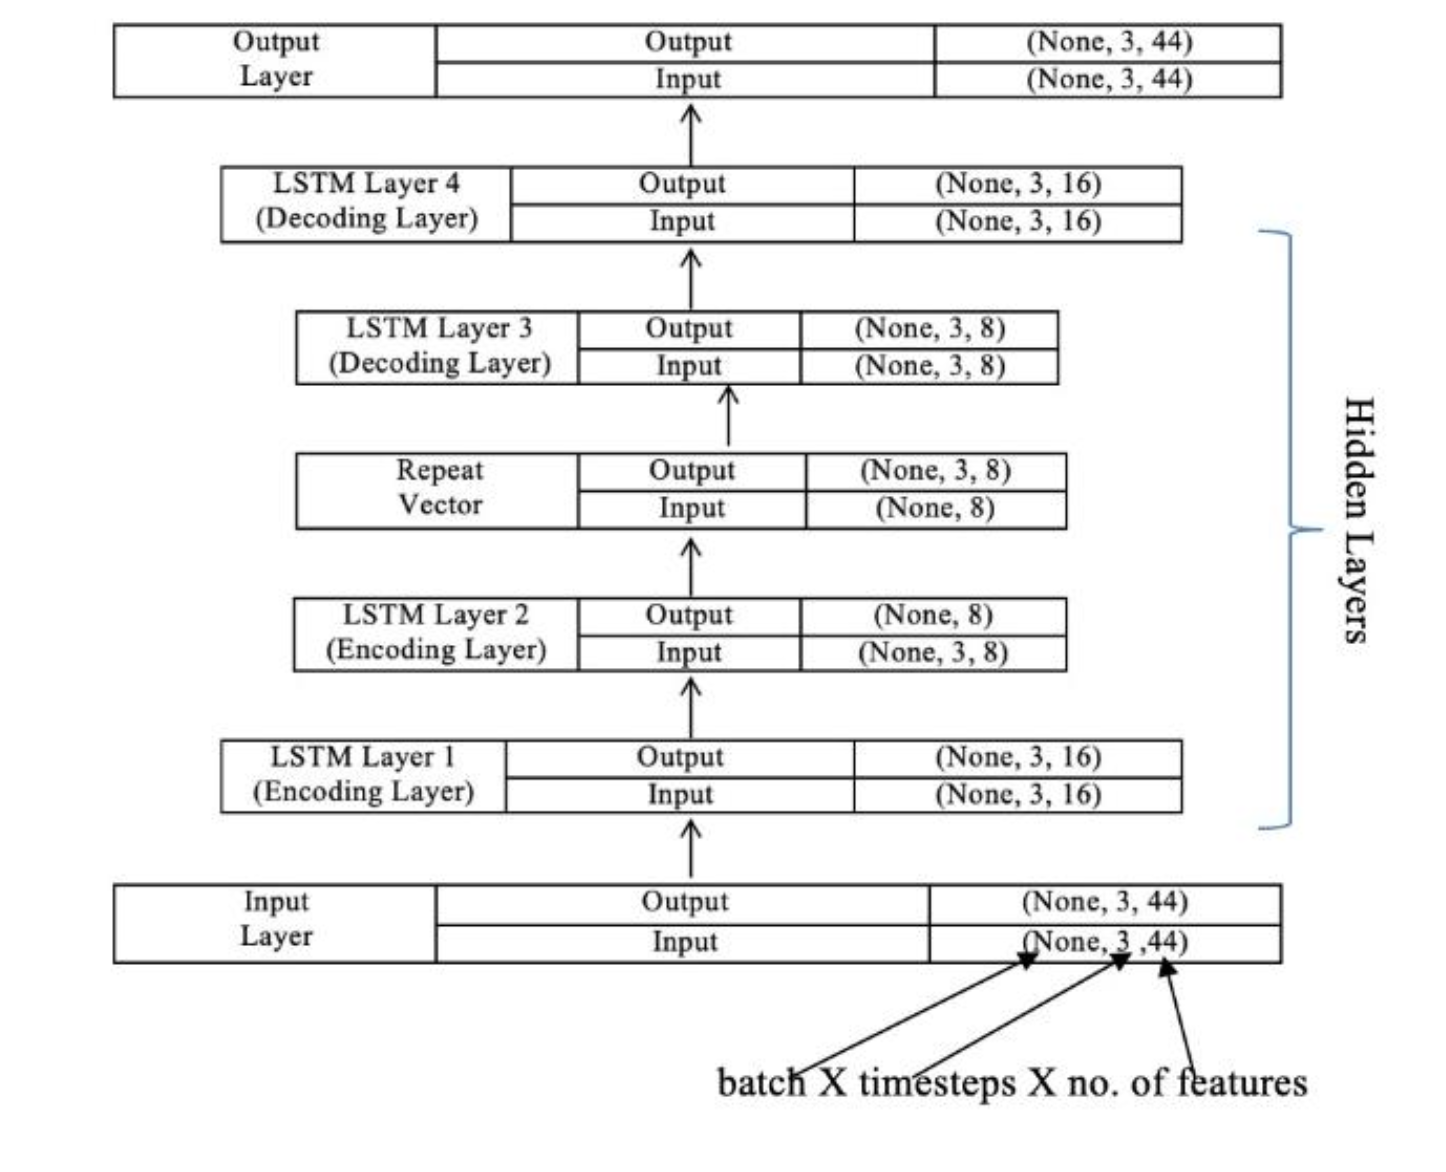

In [35]:
class AELSTM(nn.Module):

    def __init__(self, input_size):
        super(AELSTM, self).__init__()

        self.lstm1 = nn.LSTM(input_size, 16, batch_first = True)
        self.lstm2 = nn.LSTM(16, 8, batch_first = True)
        # self.lstm3 = nn.LSTM(32, 12, batch_first = True)

        # self.lstm4 = nn.LSTM(12, 32, batch_first = True)
        self.lstm5 = nn.LSTM(8, 16, batch_first = True)
        self.lstm6 = nn.LSTM(16, input_size, batch_first = True)
        self.linear = nn.Linear(input_size, input_size)

    def forward(self, input):
        seq_len = input.shape[1]
        batch_size = input.shape[0]

        X0, _ = self.lstm1(input)
        X1, _ = self.lstm2(X0)
        # X2, _ = self.lstm3(X1)

        X2 = X1[:, -1, :]
        X2 = X2.repeat(seq_len, 1)
        X2 = X2.reshape((batch_size, seq_len, 8))


        # X3, _ = self.lstm4(X2)
        X4, _ = self.lstm5(X2)
        X5, _ = self.lstm6(X4)
        X6 = self.linear(X5)
        return X6

## Train

In [36]:
batch_size = 256

AE_train = train_minmax[train_minmax['insider'] == 0]
data_loader = df_to_tensor(AE_train, batch_size, all_label = True, print_summary = True, shuffle = True)

batch_demo = iter(data_loader).next()[0]
batch_shape = batch_demo.shape
input_size = batch_shape[2]

Input DataFrame: (509422, 50) with 0.00% insiders
   => 102591 sequences (users)
       features: [4, 48], labels: [4] in size of [(max) length, dimension]
   => 401 batches in Dataloader (batchsize = 256)
       features: [256, 5, 48], labels: [256, 5], masks: [256, 5] in size of [batchsize, (max) length, dimension]



In [37]:
autoencoder = AELSTM(input_size).cuda()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)
loss_func = nn.MSELoss().cuda()

In [39]:
losslist = []
for epoch in range(100):
    batch_bar = tqdm(data_loader, leave = True)
    # for batch_i, (feature_seqs, label_seqs, mask_seqs) in enumerate(batch_bar): # get feature sequenceS, label sequenceS and mask sequenceS

    for batch_i, (x, y, mask_seqs) in enumerate(batch_bar):
        b_x = x.cuda()
        b_y = x.cuda()  

        decoded = autoencoder(b_x)

        print(decoded.shape, mask_seqs.shape)
        decoded = torch.mul(decoded, mask_seqs).reshape(-1)
        b_y = torch.mul(b_y, mask_seqs).reshape(-1)
        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()  
        
    print('Epoch: ', epoch, '| train loss: %.4f' % loss.cpu().data.numpy())

  0%|          | 0/401 [00:00<?, ?it/s]

torch.Size([256, 5, 48]) torch.Size([256, 5])


RuntimeError: ignored

## Result

In [ ]:
from sklearn.metrics.pairwise import paired_distances

def make_err_list(model, ds):
      res = []
      # assumes model.eval()
      with torch.no_grad():
          model.eval()

          batch_bar = tqdm(ds, leave = True)
          for batch_i, (x, y, mask_seqs) in enumerate(batch_bar):
              b_x = x.cuda()
              b_y = x
              # print(b_x.shape)
            
              decoded = autoencoder(b_x)

              index = int(mask_seqs.sum())
              (bach_size, seq_len, feature_len) = decoded.shape
              
              output = decoded.reshape(seq_len, feature_len).tolist()
              output_truncate = pd.DataFrame(output[:index])
              b_y = b_y.reshape(seq_len, feature_len).tolist()
              b_y_truncate = pd.DataFrame(b_y[:index])

              res = res + list(paired_distances(b_y_truncate, output_truncate))
      return res 

In [ ]:
print("\nComputing reconstruction errors ")
autoencoder.eval()  # set mode
train_data_loader = df_to_tensor(train_minmax, 1, all_label = True, print_summary = True, shuffle = False)

err_list = make_err_list(autoencoder, train_data_loader)


Computing reconstruction errors 
==== DataFrame to DataLoader ====
Input DataFrame: (510121, 50)
   => 102637 sequences (102637 users)
       features in size of [(max) length, dimension] = torch.Size([4, 48])
       labels in size of [(max) length, dimension] = torch.Size([4])
   => output DataLoader: 102637 batches (batchsize = 1)
       features in size of [batchsize, (max) length, dimension] = torch.Size([1, 4, 48])
       labels in size of [batchsize, (max) length] = torch.Size([1, 4])
       masks in size of [batchsize, (max) length] = torch.Size([1, 4])


  0%|          | 0/102637 [00:00<?, ?it/s]

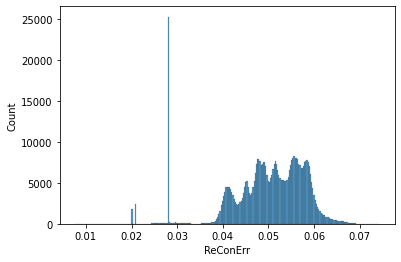

In [ ]:
sns.histplot(train['ReConErr']/48)

In [ ]:
train[train['ReConErr']/48 >=0.055].shape

(164060, 52)

In [ ]:
train['ReConErr'] = pd.array(err_list)

train.sort_values(by = 'ReConErr', ascending = False).head(51000)['insider'].value_counts()

0    50926
2       65
3        6
1        3
Name: insider, dtype: int64

In [ ]:
train['insider'].value_counts()

0    509422
2       654
1        25
3        20
Name: insider, dtype: int64

In [ ]:
199/(654+45)

0.28469241773962806

# Analysis

In [ ]:
df.groupby('insider')['ReConErr'].mean()

insider
0    417.329888
1    515.404125
Name: ReConErr, dtype: Float64

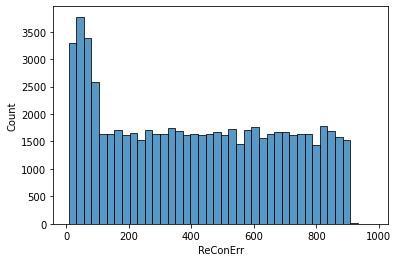

In [ ]:
sns.histplot(df['ReConErr'])

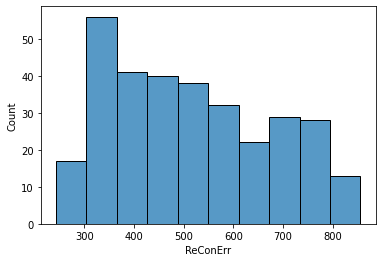

In [ ]:
sns.histplot(df.loc[df['insider']==1,'ReConErr'])

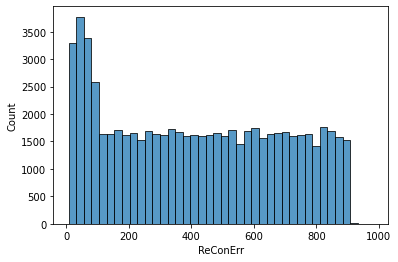

In [ ]:
sns.histplot(df.loc[df['insider']==0,'ReConErr'])

In [ ]:
print((381+15+6)/(3038+158))

0.12578222778473092


In [ ]:
data_loader = df_to_tensor(df, batch_size, all_label = True, print_summary = True, shuffle = True)

==== DataFrame to DataLoader ====
Input DataFrame: (67166, 447)
   => 1000 sequences (1000 users)
       features in size of [(max) length, dimension] = torch.Size([72, 445])
       labels in size of [(max) length, dimension] = torch.Size([72])
   => output DataLoader: 20 batches (batchsize = 50)
       features in size of [batchsize, (max) length, dimension] = torch.Size([50, 72, 445])
       labels in size of [batchsize, (max) length] = torch.Size([50, 72])
       masks in size of [batchsize, (max) length] = torch.Size([50, 72])


In [ ]:
loader = df_to_tensor(df, 1, all_label = True, print_summary = True, shuffle = False)

==== DataFrame to DataLoader ====
Input DataFrame: (67166, 448)
   => 1000 sequences (1000 users)
       features in size of [(max) length, dimension] = torch.Size([72, 446])
       labels in size of [(max) length, dimension] = torch.Size([72])
   => output DataLoader: 1000 batches (batchsize = 1)
       features in size of [batchsize, (max) length, dimension] = torch.Size([1, 72, 446])
       labels in size of [batchsize, (max) length] = torch.Size([1, 72])
       masks in size of [batchsize, (max) length] = torch.Size([1, 72])
